In [104]:
%pylab inline --no-import-all
import math
import george
import numpy as np
import scipy.stats as ss

import matplotlib.ticker as ticker
import matplotlib.cm as cmap

from george.kernels import ExpSquaredKernel

Populating the interactive namespace from numpy and matplotlib


### Besides fitting data to produce a background estimate, Gaussian Processes can also determine the underlying truth distribution from a noisy, smeared out distribution, as in for Higgs->gammagamma. To demonstarte this, we'll first start with a flat distribution, then move on to a m_gammagamma distribution. 

### First, lets test this on a fake, flat distribution

#### Initalize constants
* mean = constant mean for Gaussian Process
* init_Amp = Amplitude of exponential squared kernel for intital Gaussian Process used to make truth samples
* init_lengthscale = Lengthscale of exponential squared kernel for intital Gaussian Process to make truth samples
* gaussian_width = width of Gaussian used to smear truth sample. ~ detector resolution
* truth_step = independent coordinates for making truth samples. evenly spaced from 70 to 200 in steps of truth_step_size
* smeared_step = independent coordinates for smeared truth distrubtions. evenly spaced from 100 to 170 in steps of smeared_step_size. Smeared step size ~ detector resolution


In [105]:
mean = 50.
init_Amp = 10.
init_lengthscale = 1.
gaussian_width=2.
pull=[]

In [106]:
truth_step_size=0.1
truth_steps = np.arange(70, 200, truth_step_size)
smeared_step_size=1.
smeared_steps = np.arange(100, 180, smeared_step_size)

#### Plots
* draw_pulls = Pass in pulls and amplitude scaling of squared exponential kernel (only used in title of figure). Draw normalized histogram of pulls with N(0,1) on top of it. 
* plot_truth = Plot truth, smeared, and noisy smeared distributions
* plot_GP = Plot smeared, noisy, and Gaussian Process distributions with $1\sigma$ error on the Gaussian Process


In [107]:
def draw_pulls(pulls, amp_scale):
    plt.figure()
    bins=np.linspace(-2,2,50)

    pull_mean = np.mean(pulls)
    pull_std = np.std(pulls)

    n,_,_=plt.hist(pulls, bins=bins, normed=True)
    plt.plot(bins, ss.norm.pdf(bins, pull_mean, pull_std), c='black', linewidth='3', label="N({:.1f}, {:.1f})".format(pull_mean, pull_std))
    plt.plot(bins, ss.norm.pdf(bins, 0,1), c='r', linewidth='3', label="N(0,1)")
    print "mean, std = ", (pull_mean, pull_std)

    plt.xlabel("(GP-Smeared)/GP Uncertainty", fontsize=20)
    plt.title("Kernel Amplitude = "+str(amp_scale), fontsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.tick_params(axis='x', labelsize=20)
    plt.legend()

In [108]:
def plot_truth(smeared, noisy, truth, doLogy=False, doLogx=False):
    plt.figure(figsize(10,8))
    plt.ylabel('Events', fontsize=20)
    plt.xlabel(r'$m_{\gamma\gamma}$', fontsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.tick_params(axis='x', labelsize=20)

    if doLogy:
        plt.yscale("log")
    if doLogx:
        plt.xscale("log")
    
    plt.plot(smeared_steps,smeared, c='crimson', linewidth=3, alpha=0.5,label="smeared distribution")
    plt.errorbar(smeared_steps,noisy, yerr=np.sqrt(noisy), markersize = '3', marker='o', ls='None', c='black', label="smeared MC samples")
    plt.plot(truth_steps, truth, c='goldenrod', linewidth=3, alpha=0.5, label="truth distribution")
    plt.legend()
    plt.xlim([100,180])

In [109]:
def plot_GP(smeared, noisy, GPmean, GPstd, doLogy=False, doLogx=False):
    plt.figure(figsize(10,8))
    plt.ylabel('Events', fontsize=20)
    plt.xlabel(r'$m_{\gamma\gamma}$', fontsize=20)
    plt.xlim([100,180])
    plt.tick_params(axis='y', labelsize=20)
    plt.tick_params(axis='x', labelsize=20)

    if doLogy:
        plt.yscale("log")
    if doLogx:
        plt.xscale("log")
        
    plt.plot(smeared_steps, smeared, c='crimson', linewidth=3, label='smeared distribution')
    plt.plot(smeared_steps, GPmean, c='b', linewidth=3, label="GP")
    plt.fill_between(smeared_steps, GPmean-GPstd, GPmean+GPstd, facecolor='cornflowerblue', alpha=0.5, label=r"GP $1\sigma$ error")
    plt.errorbar(smeared_steps,noisy, yerr=np.sqrt(noisy), marker='o', markersize='3', ls='None', c='black', label="smeared MC samples")
    plt.legend()

### Making up truth distrubtions from a Gaussian Process with a squared exponential kernel.
* set up kernel with initial amplitude and lengthscale
* intialize GP object with kernel and constant mean
* compute precomputes covariance matrix at x coordinates truth_steps. Second argument is a white noise constant added to diagonal of covariance matrix
* sample draws from Gaussian Process prior

(70, 200)

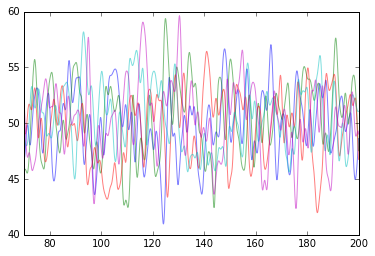

In [110]:
initial_kernel = init_Amp * ExpSquaredKernel(init_lengthscale)
initial_gp = george.GP(initial_kernel, mean=mean)
initial_gp.compute(truth_steps, 1e-8)
samples=[[s if s > 0 else 0 for s in initial_gp.sample(truth_steps,100)[i]] for i in range(100)]
for s in samples[:5]:
    plt.plot(truth_steps,s, alpha=0.5)
plt.xlim([70, 200])

#### Function definitions
* smear = Pass in truth sample. Smear truth distribution with a Gaussian, add Poisson noise on top of this. Return smeared and noisy smeared distributions
* makeGP = Pass in noisy smeared distribution and amplitude scaling of squared exponential kernel. Return mean and standard deviation of the predicitive distribution 

In [114]:
def smear(s, truthStepSize, truthSteps, smearedSteps, gaussianWidth):
    smeared_counts=np.zeros(len(smearedSteps))
    for xi, x in enumerate(smearedSteps):
        gaus = truthStepSize*ss.norm.pdf(x, truthSteps, gaussianWidth)
        smeared_counts[xi]=np.sum(s*gaus)
    noisy_smeared_counts=np.random.poisson(smeared_counts)
    return smeared_counts, noisy_smeared_counts

In [122]:
def makeGP(counts, smearedSteps, gaussianWidth, amp_scale=1., mean=mean):
    kernel = amp_scale*init_Amp * ExpSquaredKernel(init_lengthscale*gaussianWidth*np.sqrt(2))
    gp = george.GP(kernel, mean=mean)
    gp.compute(smearedSteps, yerr=np.sqrt(counts))
    meanGP, covGP = gp.predict(counts, smearedSteps)
    stdGP = np.sqrt(np.diag(covGP))
    return meanGP, stdGP

#### Loop over prior samples from truth Gaussian Process. 
* Smear truth
* Add noise
* Fit with Gaussian Process
* Calculate pulls

In [116]:
for samp in samples:
    smeared_counts, noisy_smeared_counts = smear(samp, truth_step_size, truth_steps, smeared_steps, gaussian_width)
    meanGP, stdGP = makeGP(noisy_smeared_counts, smeared_steps, gaussian_width, 1.)
    pull+=list((meanGP-smeared_counts)/stdGP)

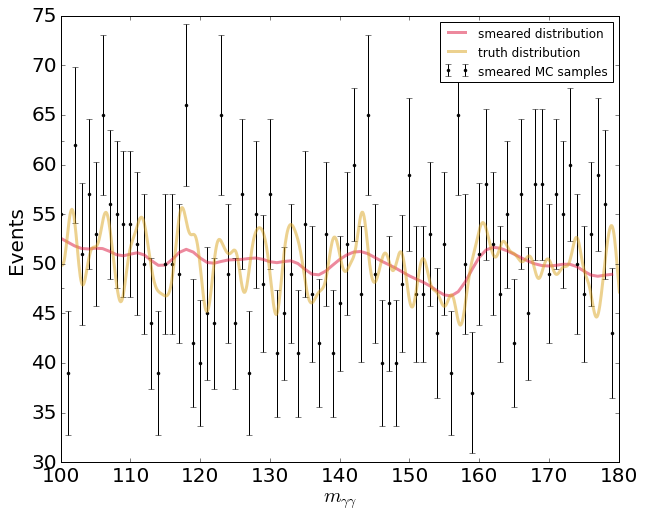

In [117]:
plot_truth(smeared_counts, noisy_smeared_counts, samples[-1])

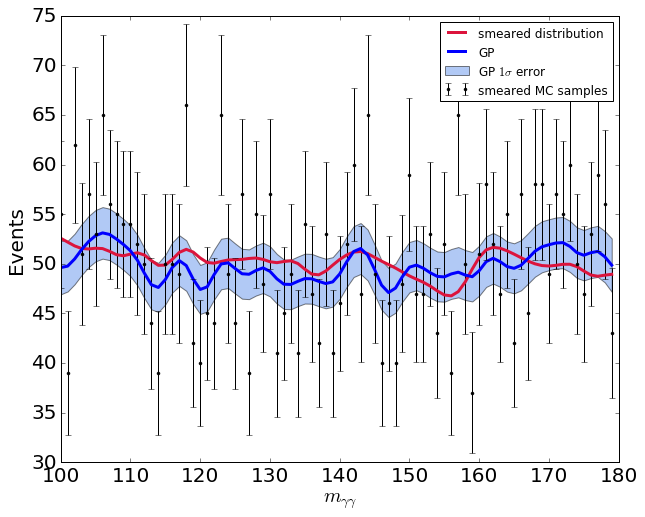

In [118]:
plot_GP(smeared_counts, noisy_smeared_counts, meanGP, stdGP)

mean, std =  (-0.16306063394058146, 0.74043994809669389)


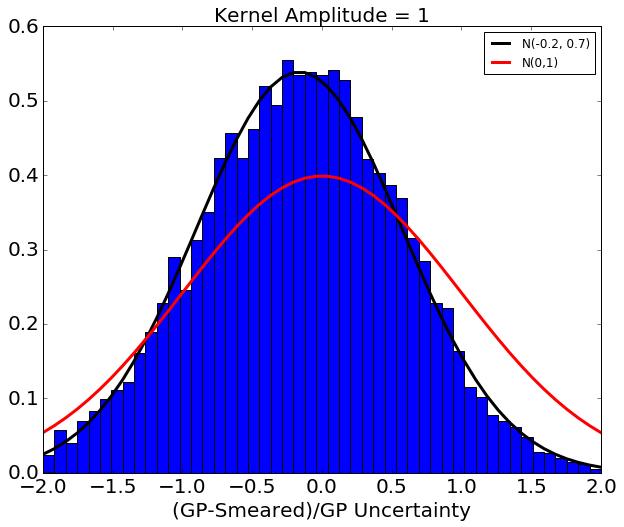

In [119]:
draw_pulls(pull, 1)

#### Calculate and draw pulls for multiple amplitude scales of the Gaussian Process kernel fit

mean, std =  (-0.079221062010163185, 1.7717227598058776)
mean, std =  (-0.15727492873868665, 0.73455587959007262)
mean, std =  (-0.16269235074537533, 0.87603902780741583)
mean, std =  (-0.11866557197743145, 0.96714823372719549)
mean, std =  (-0.11214730526931192, 0.98332226313292326)


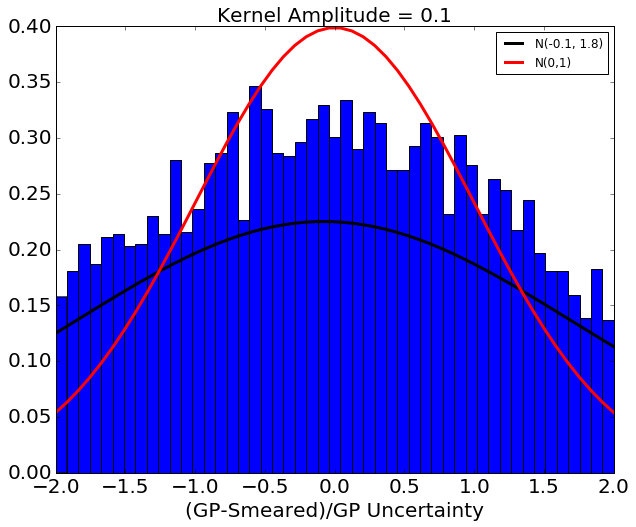

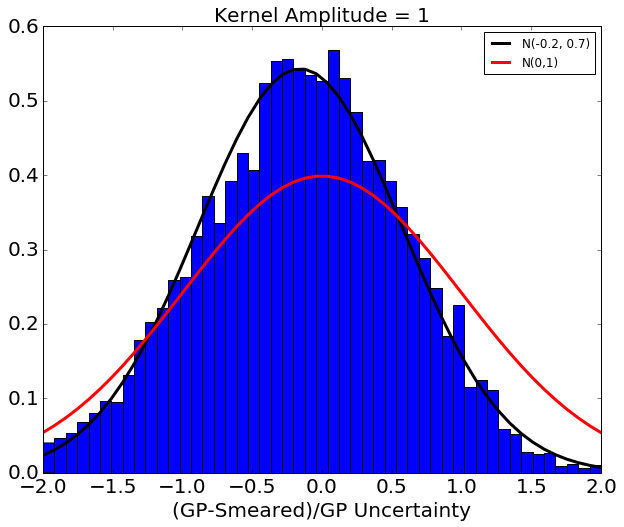

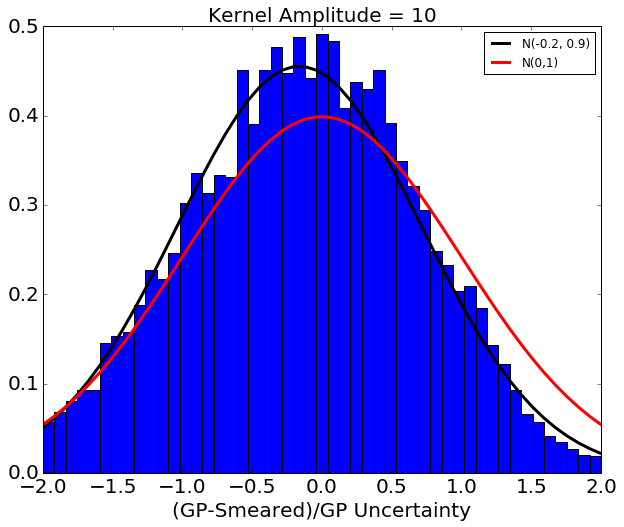

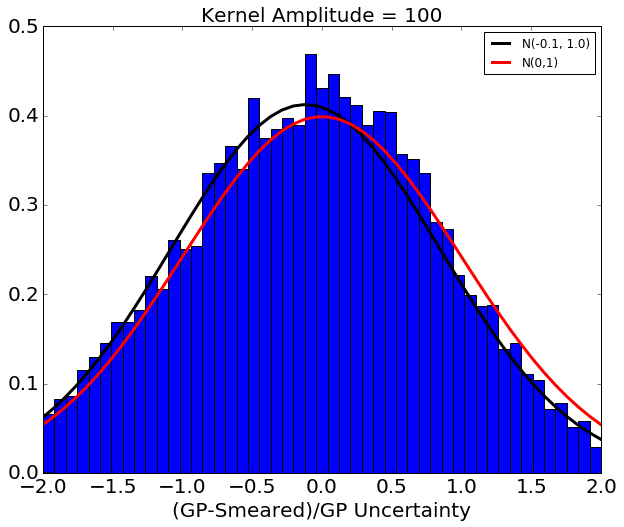

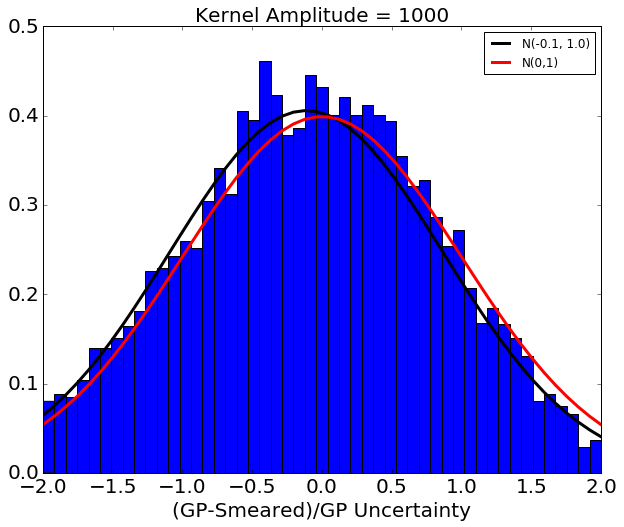

In [121]:
ampscales=[0.1,1,10, 100, 1000]
pulls={}
for amp in ampscales:
    pulls[amp]=[]
    for samp in samples:
        smeared_counts, noisy_smeared_counts = smear(samp, truth_step_size, truth_steps, smeared_steps, gaussian_width)
        meanGP, stdGP = makeGP(noisy_smeared_counts, smeared_steps, gaussian_width, amp)
        pulls[amp]+=list((meanGP-smeared_counts)/stdGP)
    plt.figure()
    draw_pulls(pulls[amp], amp)

##########################################

### Now, lets try with a realistic distribution. One of the functions used in the Higgs->gammagamma analysis is an exponential, so lets try to fit that.

In [123]:
pull=[]

#### Since I know what the mgammagamma distribution looks like, I'm picking the parameters of the exponential to match

In [124]:
def expo(t):
    A, B = (1700, 0.02)
    return A*np.exp(-t*B)

mean, std =  (-0.10041803997326537, 0.89051159704122296)
mean, std =  (-0.12242538453155768, 1.7813800531417774)
mean, std =  (-0.12187988040722898, 0.67827692182804178)
mean, std =  (-0.11753583381507772, 0.80819943435181263)
mean, std =  (-0.093685369788833628, 0.93023842471359719)


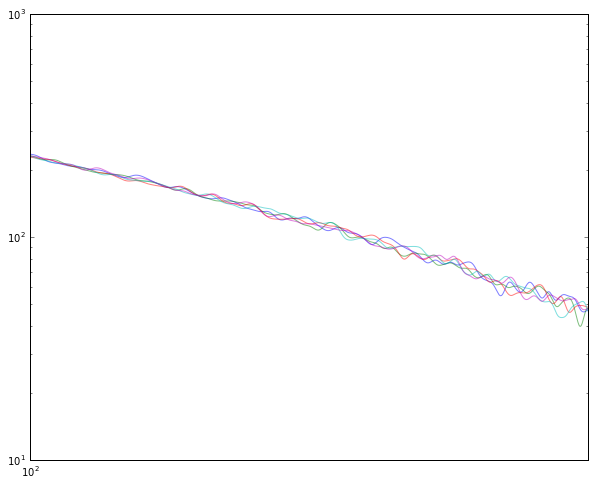

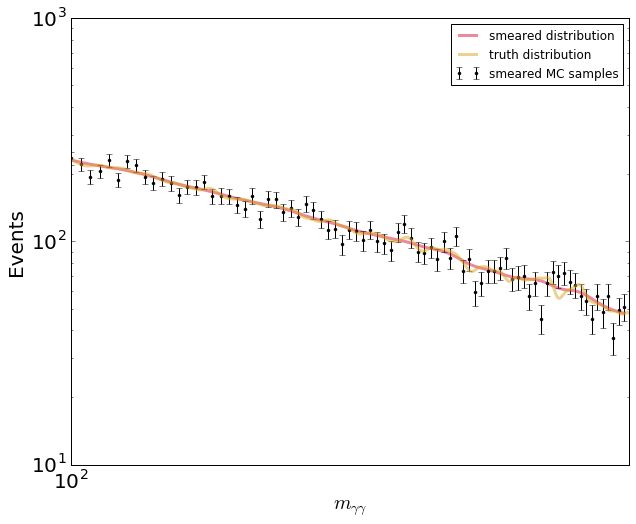

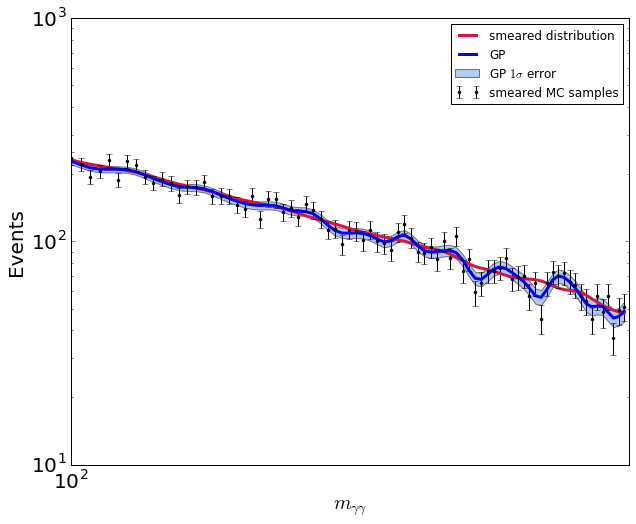

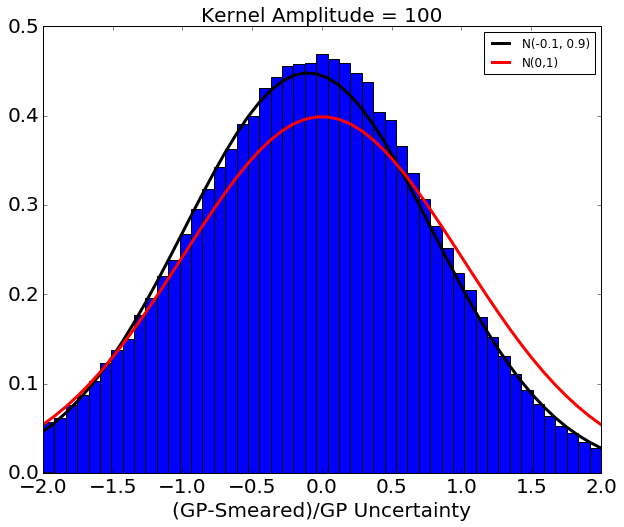

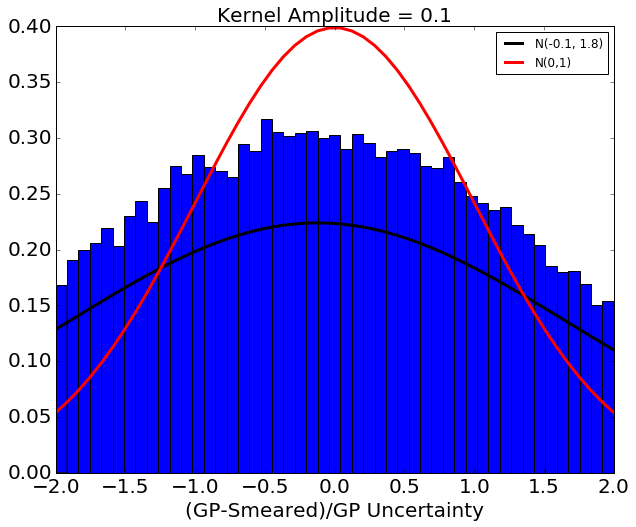

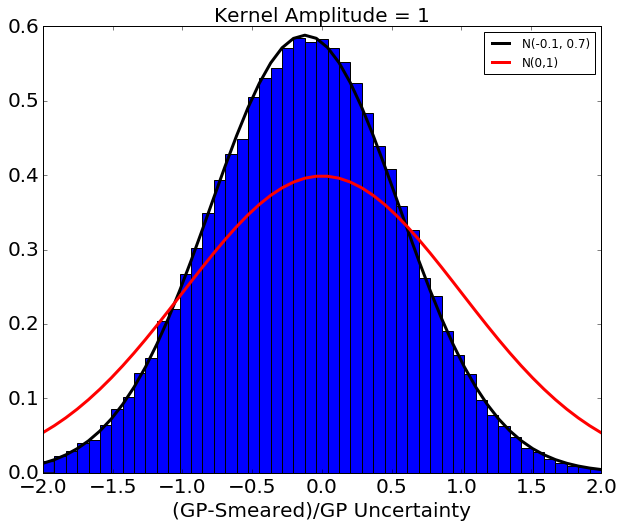

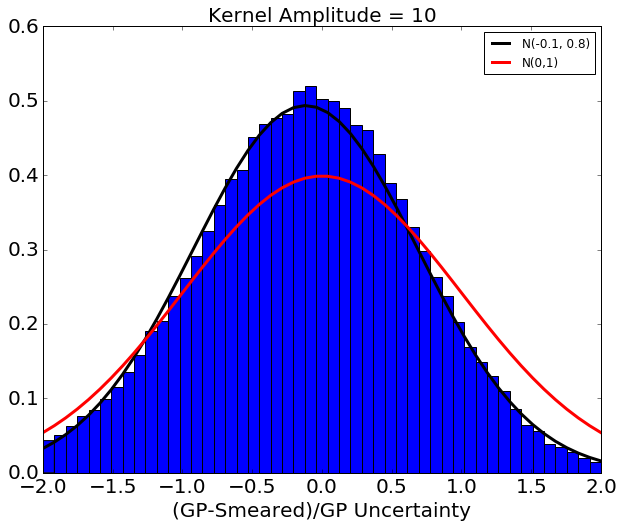

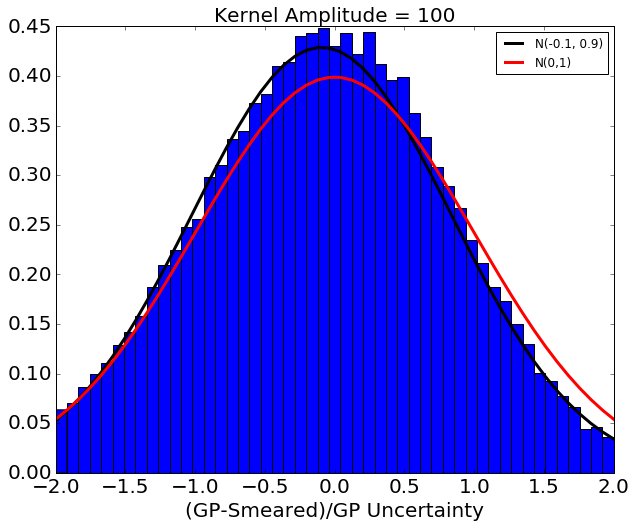

In [127]:
initial_kernel = init_Amp * ExpSquaredKernel(init_lengthscale)
initial_gp = george.GP(initial_kernel, mean=expo)
initial_gp.compute(truth_steps, 1e-2)
samples=initial_gp.sample(truth_steps,1000)
plt.figure()
for s in samples[:5]:
    plt.plot(truth_steps,s, alpha=0.5)
plt.xlim([100,180])
plt.xscale('log')
plt.yscale('log')

for samp in samples:
    smeared_counts, noisy_smeared_counts = smear(abs(samp),truth_step_size, truth_steps, smeared_steps, gaussian_width)
    meanGP, stdGP = makeGP(noisy_smeared_counts, smeared_steps, gaussian_width, 10., expo)
    pull+=list((meanGP-smeared_counts)/stdGP)

plot_truth(smeared_counts, noisy_smeared_counts, samples[-1], True, True)
plot_GP(smeared_counts, noisy_smeared_counts, meanGP, stdGP, True, True)
draw_pulls(pull, 100)


ampscales=[0.1,1,10, 100]
pulls={}
for amp in ampscales:
    pulls[amp]=[]
    for samp in samples:
        smeared_counts, noisy_smeared_counts = smear(abs(samp), truth_step_size, truth_steps, smeared_steps, gaussian_width)
        meanGP, stdGP = makeGP(noisy_smeared_counts, smeared_steps, gaussian_width, amp, expo)
        pulls[amp]+=list((meanGP-smeared_counts)/stdGP)
    plt.figure()
    draw_pulls(pulls[amp], amp)